## Chapter 4

### Gambler's Problem (Example 4.2 page 84)

In [1]:
from pprint import pprint
from tqdm import tqdm

import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")

import util as c4
from chapter04.gambler import *
from mdp.unit import Status, SelectA
from mdp.learning import Algorithms
import mdp.util as util

In [2]:
agent = Gambler(CoinFlips(s=Capital(cap=20)))

### Watch the random gambler play

In [3]:
agent.π.strategy, agent.v_iter = Strategy.off, False
steps = c4util.episode(agent)
pprint(steps)

[T(t=0, s=Capital(cap=20), a=Stake(amount=2), r=0, rn=0),
 T(t=1, s=Capital(cap=18), a=Stake(amount=7), r=0, rn=0),
 T(t=2, s=Capital(cap=11), a=Stake(amount=3), r=0, rn=0),
 T(t=3, s=Capital(cap=14), a=Stake(amount=8), r=0, rn=0),
 T(t=4, s=Capital(cap=22), a=Stake(amount=9), r=0, rn=0),
 T(t=5, s=Capital(cap=31), a=Stake(amount=25), r=0, rn=0),
 T(t=6, s=Capital(cap=6), a=Stake(amount=3), r=0, rn=0),
 T(t=7, s=Capital(cap=3), a=Stake(amount=2), r=0, rn=0),
 T(t=8, s=Capital(cap=5), a=Stake(amount=0), r=0, rn=0),
 T(t=9, s=Capital(cap=5), a=Stake(amount=0), r=0, rn=0),
 T(t=10, s=Capital(cap=5), a=Stake(amount=4), r=0, rn=0),
 T(t=11, s=Capital(cap=1), a=Stake(amount=1), r=0, rn=0),
 T(t=12, s=Capital(cap=0), a=Stake(amount=0), r=0, rn=0)]


### Learn the value function and optimal policy

In [4]:
states = agent.env.all_sn(agent.env.s)
v = Algorithms.value_iteration(agent, states)
agent.reset(Capital(20))

Policy(name='smallest_optimal', strategy=<Strategy.off: 1>, v=V(t=21, γ=1.0, θ=0.0000010, Δ=0.0000000), require_stable=True, ε=0.0, es=False, converged=True, changes=0, stable=4)


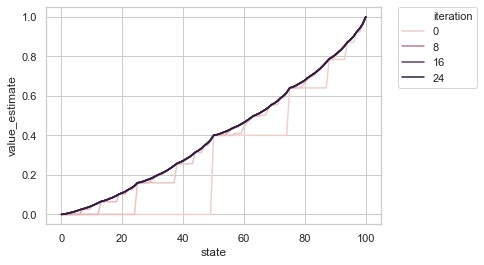

Figure 4.3


In [5]:
c4.plot_values(agent)
print('Figure 4.3')

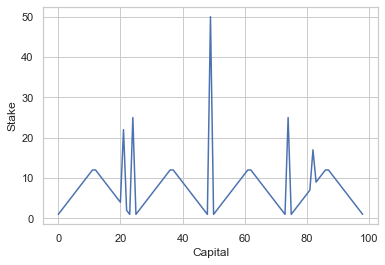

Figure 4.3


In [6]:
c4.plot_policy(agent)
print('Figure 4.3')

The value iteration looks correct. The couple extra jaggies from the book result are due to floating point errors.

### Watch the skilled gambler play

In [7]:
print(agent.π.name)
agent.π.strategy = Strategy.on
steps = c4util.episode(agent)
pprint(steps)

smallest_optimal
[T(t=0, s=Capital(cap=20), a=Stake(amount=5), r=0, rn=0),
 T(t=1, s=Capital(cap=15), a=Stake(amount=10), r=0, rn=0),
 T(t=2, s=Capital(cap=25), a=Stake(amount=25), r=0, rn=0),
 T(t=3, s=Capital(cap=0), a=Stake(amount=0), r=0, rn=0)]


### Compare optimal and random players

In [8]:
import pandas as pd

def where(df, func):
    return df[func(df)]

pd.DataFrame.where = where

results = {'agent': [], 'starting_capital': [], 'result': [], 'steps': []}
n = 25_000

def update_results(r, agent):
    name = {'none': 'random', 'random': 'value', 'smallest_optimal': 'optimal', 'empirical': 'empirical', 'mc': 'mc', 'episodic_value': 'episodic_value'}
    r['agent'] += [name[agent.π.name]]
    r['starting_capital'] += [agent.env.first_s.cap]
    r['result'] += [agent.env.s.terminal().value]
    r['steps'] += [agent.env.t]
    return r

In [9]:
agent_random = Gambler(CoinFlips(), π=Policy('none', strategy=Strategy.off))
for i in tqdm(range(n)):
    agent_random.reset(), agent_random.env.reset(s=Capital(np.random.randint(20, 60)))
    while agent_random.env.s.terminal() == Status.play:
        _ = agent_random.act()
    results = update_results(results, agent_random)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:07<00:00, 3473.02it/s]


In [10]:
agent.π.strategy = Strategy.on
for i in tqdm(range(n)):
    agent.reset(), agent.env.reset(s=Capital(np.random.randint(20, 60)))
    while agent.env.s.terminal() == Status.play:
        _ = agent.act()
    results = update_results(results, agent)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:02<00:00, 8753.44it/s]


In [11]:
rdf = pd.DataFrame(results)
rdf['result'] = rdf['result'].apply(lambda x: 'win' if x == 1 else 'lose')

#### Win rates

In [12]:
wins = rdf.groupby(['agent', 'result']).count().reset_index()
random_wins = wins \
    .where(lambda x: x['agent'] == 'random') \
    .where(lambda x: x['result'] == 'win') \
    .reset_index()['steps'][0]

print(f'Random win rate: {100 * random_wins / n}%')

Random win rate: 79.852%


In [13]:
optimal_wins = wins \
    .where(lambda x: x['agent'] == 'optimal') \
    .where(lambda x: x['result'] == 'win') \
    .reset_index()['steps'][0]

print(f'Optimal win rate: {100 * optimal_wins / n}%')

Optimal win rate: 72.288%


#### Win times

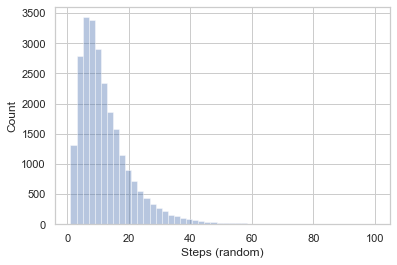

In [14]:
ax = sns.distplot(rdf.where(lambda x: x['agent'] == 'random')['steps'], kde=False)
_ = ax.set(xlabel='Steps (random)', ylabel='Count')

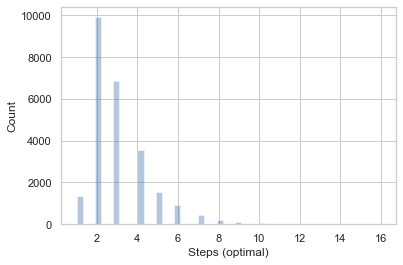

In [15]:
ax = sns.distplot(rdf.where(lambda x: x['agent'] == 'optimal')['steps'], kde=False)
_ = ax.set(xlabel='Steps (optimal)', ylabel='Count')

The trained gambler has much shorter runs, resulting in victory more often.

In [16]:
rdf['log_steps'] = rdf['steps'].apply(lambda x: np.log(x))

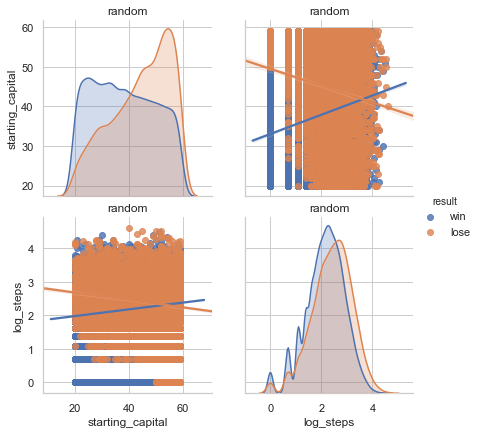

In [17]:
g = sns.pairplot(rdf.where(
    lambda x: x['agent'] == 'random').drop(columns=['steps']),
    hue='result', hue_order=['win', 'lose'], kind='reg', height=3
)
_ = g.set(title='random')

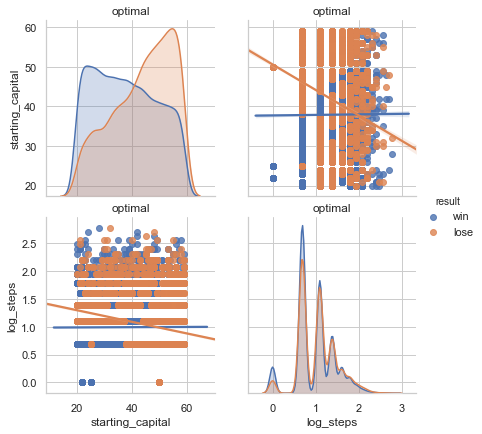

In [18]:
g = sns.pairplot(
    rdf.where(lambda x: x['agent'] == 'optimal').drop(columns=['steps']),
    hue='result', hue_order=['win', 'lose'], kind='reg', height=3
)
_ = g.set(title='optimal')

### Simulating Data

Two different simulation algorithms are used: Monte Carlo episodic with exploring starts, and value iteration with incremental probability updates.

#### Monte Carlo Exploring Starts

In [19]:
π = Policy(
    name='mc',
    v=V(γ=1.0, θ=1e-3, use_rn=False, v_init={}),
    strategy=Strategy.off,  # off policy
    select=c4.rand_non_zero,  # pick a best action with averaged value (1/n prob)
    behavior = lambda s, actions: choice(actions)  # random behavior
)
agent_mc = Gambler(CoinFlips(), π=π)
print(agent_mc.π)

Policy(name='mc', strategy=<Strategy.off: 1>, v=V(t=0, γ=1.0, use_rn=F, θ=0.0010000, Δ=1000.0000000), require_stable=False, ε=0.0, es=False, converged=False, changes=0, stable=1)


In [20]:
_ = Algorithms.mc_exploring_starts(episode=c4.episode, agent=agent_mc, kwargs={}, n=200_000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [02:11<00:00, 1521.35it/s]


Using `rand_non_zero()` to select action-values.
Doc string: Use max non-zero stake action-value.


In [21]:
df = pd.DataFrame(agent_mc.π.v.swp)
df['capital'] = df['state'].apply(lambda x: x.cap)

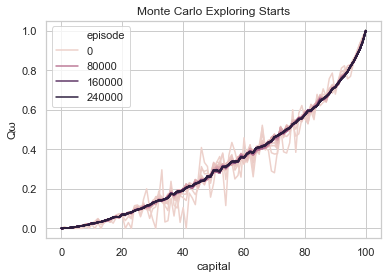

In [22]:
ax = sns.lineplot(y="Qω", x="capital", hue="episode", data=df)
_ = ax.set_title('Monte Carlo Exploring Starts')

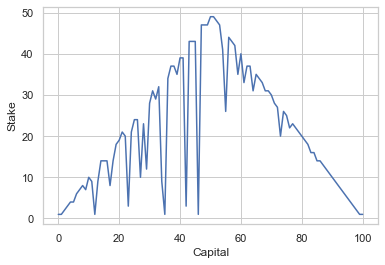

In [23]:
c4.plot_policy(agent_mc)

#### Episodic Value Iteration

Instead of providing apriori probabilities to the value iteration (e.g. p_heads = 0.4), it is possible to learn these stationary probabilities over time by playing episodes. In this way, the probability estimate improves each iteration while the time complexity remains constant.

In practice, a discounted value estimate lengthens the number of sweeps but reduces the need for really good initial priority estimates, because past results with fewer total simulations are weighted less. So a discount is applied.

In [24]:
π = Policy(
    name='episodic_value',
    v=V(γ=1.0, θ=1e-3, v_init={Capital(100): Y(v=1.0, vp=1.0)}),
    strategy=Strategy.off,  # off policy
    select=c4.rand_non_zero,  # pick a best action with averaged value (1/n prob)
    behavior = lambda s, actions: choice(actions)  # random behavior
)
agent_ep_value = Gambler(CoinFlips(), π=π)
print(agent_ep_value.π)

Policy(name='episodic_value', strategy=<Strategy.off: 1>, v=V(t=0, γ=1.0, θ=0.0010000, Δ=0.0000000), require_stable=False, ε=0.0, es=False, converged=True, changes=0, stable=1)


In [25]:
_ = Algorithms.episodic_value_iteration(episode=c4.episode, agent=agent_ep_value, kwargs={}, n=200_000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [04:10<00:00, 798.50it/s]


In [26]:
df = pd.DataFrame(agent_ep_value.π.v.swp)
df['capital'] = df['state'].apply(lambda x: x.cap)

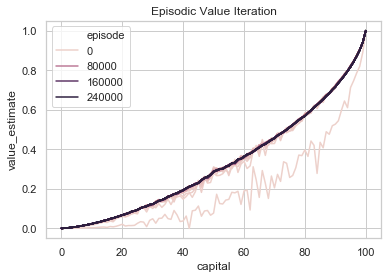

In [27]:
ax = sns.lineplot(y="value_estimate", x="capital", hue="episode", data=df)
_ = ax.set_title('Episodic Value Iteration')

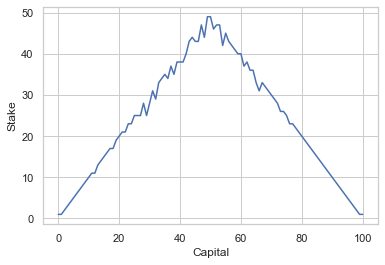

In [28]:
c4.plot_policy(agent_ep_value)

Both simulated methods have value shapes similar to the theoretical optimal, and policies that attempt to make the max stake every time.

### Play many times and compare to the optimal value iteration agent

In [29]:
agent_mc.π.strategy = Strategy.on
for i in tqdm(range(n)):
    agent_mc.reset(), agent_mc.env.reset(s=Capital(np.random.randint(20, 60)))
    while agent_mc.env.s.terminal() == Status.play:
        _ = agent_mc.act()
    results = update_results(results, agent_mc)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:03<00:00, 7423.32it/s]


In [30]:
agent_ep_value.π.strategy = Strategy.on
for i in tqdm(range(n)):
    agent_ep_value.reset(), agent_ep_value.env.reset(s=Capital(np.random.randint(20, 60)))
    while agent_ep_value.env.s.terminal() == Status.play:
        _ = agent_ep_value.act()
    results = update_results(results, agent_ep_value)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:02<00:00, 11514.68it/s]


In [31]:
rdf = pd.DataFrame(results)
rdf['result'] = rdf['result'].apply(lambda x: 'win' if x == 1 else 'lose')

#### Win rate

In [32]:
wins = rdf.groupby(['agent', 'result']).count().reset_index()
mc_wins = wins \
    .where(lambda x: x['agent'] == 'mc') \
    .where(lambda x: x['result'] == 'win') \
    .reset_index()['steps'][0]
ep_value_wins = wins \
    .where(lambda x: x['agent'] == 'episodic_value') \
    .where(lambda x: x['result'] == 'win') \
    .reset_index()['steps'][0]

print(f'MC win rate: {100 * mc_wins / n}%')
print(f'Episodic value iteration win rate: {100 * ep_value_wins / n}%')

MC win rate: 73.68%
Episodic value iteration win rate: 73.38%


#### Win times

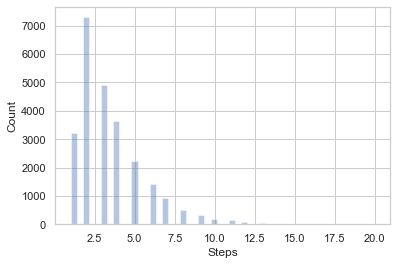

In [33]:
ax = sns.distplot(rdf.where(lambda x: x['agent'] == 'mc')['steps'], kde=False)
_ = ax.set(xlabel='Steps', ylabel='Count')

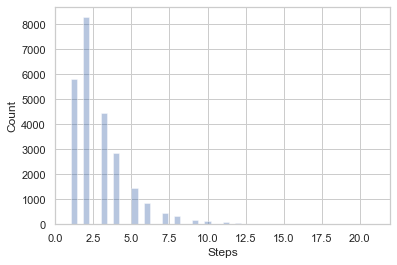

In [34]:
ax = sns.distplot(rdf.where(lambda x: x['agent'] == 'episodic_value')['steps'], kde=False)
_ = ax.set(xlabel='Steps', ylabel='Count')

#### Compared to optimal

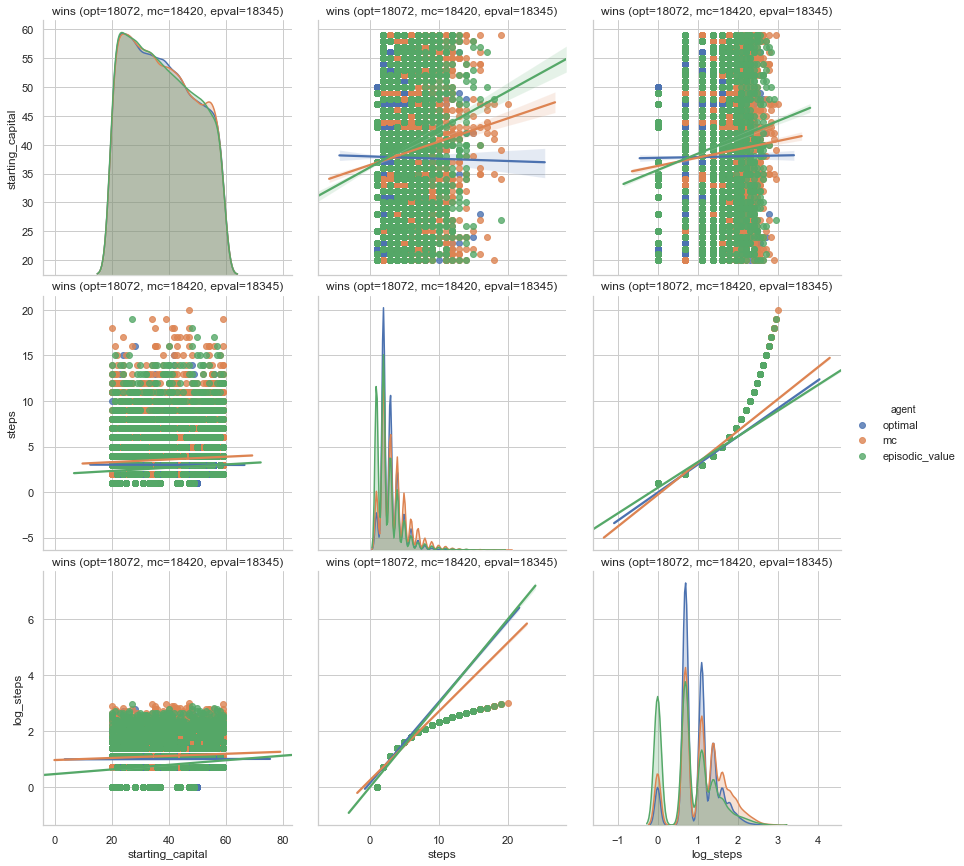

In [35]:
rdf['log_steps'] = rdf['steps'].apply(lambda x: np.log(x))
g = sns.pairplot(
    rdf.where(lambda x: (x['agent'] != 'random') & (x['result'] == 'win')).drop(columns=[]),
    hue='agent', kind='reg', height=4
)
_ = g.set(title=f'wins (opt={optimal_wins}, mc={mc_wins}, epval={ep_value_wins})')

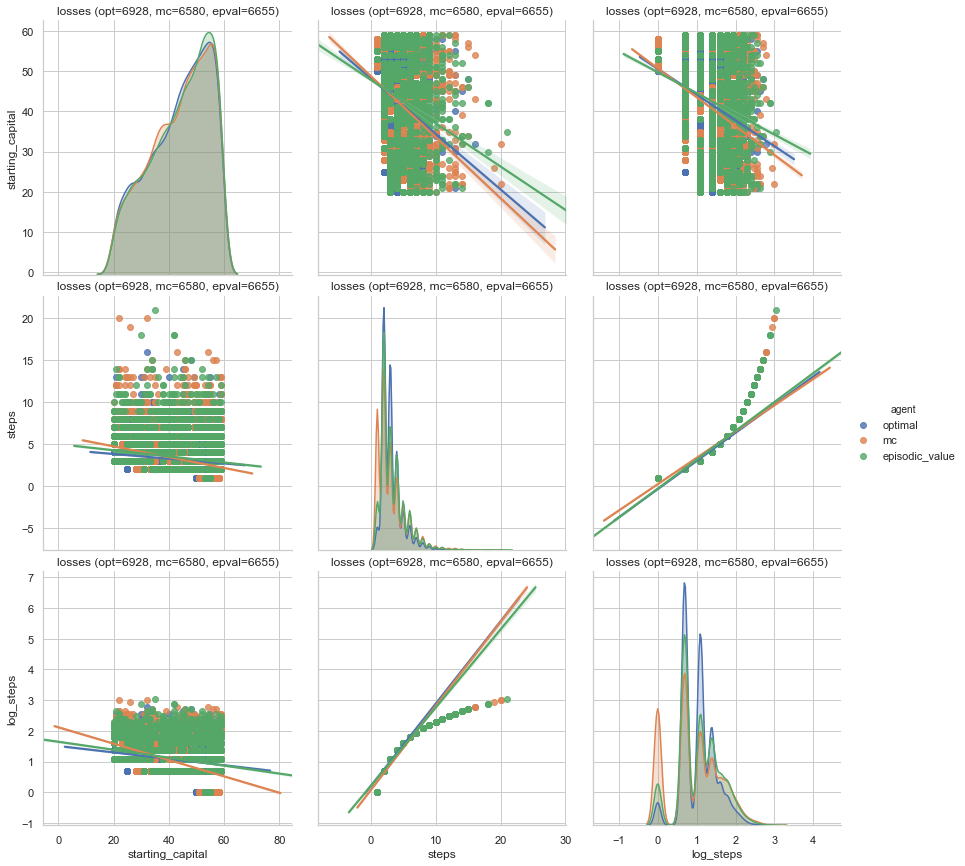

In [36]:
rdf['log_steps'] = rdf['steps'].apply(lambda x: np.log(x))
g = sns.pairplot(
    rdf.where(lambda x: (x['agent'] != 'random') & (x['result'] == 'lose')).drop(columns=[]),
    hue='agent', kind='reg', height=4
)
_ = g.set(title=f'losses (opt={n-optimal_wins}, mc={n-mc_wins}, epval={n-ep_value_wins})')

The simulated agents have similar win rates and win times to the optimal policy agent. The value estimates are noisier but good enough to find a decent policy. The monte carlo exploring starts loses more slowly but wins more slowly, too. The episodic value iteration policy is most similar to value iteration.